# Pos Tagging

The purpose of pos tagging to get the potential aspect terms in each sentence. For sentences without aspects being detect will be directed to the sentence embedding extraction section.
The pos tagging model used here is from [Flair](https://github.com/flairNLP/flair), a library to perform NLP processing. This project revolves around using this library.

In [1]:
from datasets import load_from_disk
laptop_dataset = load_from_disk('../data_2016/preprocessed_data/laptop_dataset')
restaurant_dataset = load_from_disk('../data_2016/preprocessed_data/restaurant_dataset')

Extract Laptop Pos Tags

In [2]:
from unsupervised_absa.tagger import Tagger
tagger = Tagger('pos', device='cuda')
laptop_df = laptop_dataset.to_pandas()
laptop_df['pos_tag'] = tagger.tagging(laptop_df['text'], filter_tags=["NN", "NNS"])

2023-04-23 19:42:35,102 SequenceTagger predicts: Dictionary with 53 tags: <unk>, O, UH, ,, VBD, PRP, VB, PRP$, NN, RB, ., DT, JJ, VBP, VBG, IN, CD, NNS, NNP, WRB, VBZ, WDT, CC, TO, MD, VBN, WP, :, RP, EX, JJR, FW, XX, HYPH, POS, RBR, JJS, PDT, NNPS, RBS, AFX, WP$, -LRB-, -RRB-, ``, '', LS, $, SYM, ADD


2023-04-23 19:42:46.218 | INFO     | unsupervised_absa.tagger:__init__:32 - Tagger model instantiated with device: cuda
2023-04-23 19:42:46.234 | INFO     | unsupervised_absa.tagger:tagging:38 - Extracting pos tags
100%|██████████| 2488/2488 [10:09<00:00,  4.08it/s]


Extract Restaurant Pos Tags

In [3]:
from unsupervised_absa.tagger import Tagger
tagger = Tagger('pos', device='cuda')
restaurant_df = restaurant_dataset.to_pandas()
restaurant_df['pos_tag'] = tagger.tagging(restaurant_df['text'], filter_tags=["NN", "NNS"])

2023-04-23 19:52:56,695 SequenceTagger predicts: Dictionary with 53 tags: <unk>, O, UH, ,, VBD, PRP, VB, PRP$, NN, RB, ., DT, JJ, VBP, VBG, IN, CD, NNS, NNP, WRB, VBZ, WDT, CC, TO, MD, VBN, WP, :, RP, EX, JJR, FW, XX, HYPH, POS, RBR, JJS, PDT, NNPS, RBS, AFX, WP$, -LRB-, -RRB-, ``, '', LS, $, SYM, ADD


2023-04-23 19:52:57.191 | INFO     | unsupervised_absa.tagger:__init__:32 - Tagger model instantiated with device: cuda
2023-04-23 19:52:57.203 | INFO     | unsupervised_absa.tagger:tagging:38 - Extracting pos tags
 30%|███       | 603/1990 [02:29<04:34,  5.06it/s]

2023-04-23 19:55:27,151 Warning: An empty Sentence was created! Are there empty strings in your dataset?


100%|██████████| 1990/1990 [06:42<00:00,  4.94it/s]


In [19]:
def remap_term(opinions):
    out = []
    for x in opinions:
        result = {
            'start': x['from'],
            'end': x['to'],
            'polarity': x['polarity'],
            'term': x['target'],
            'category': x['category'].split('#')[0]
        }
        out.append(result)
    return out

In [20]:
def remap_category(opinions):
    out = []
    for x in opinions:
        result = {
            'polarity': x['polarity'],
            'category': x['category'].split('#')[1]
        }
        out.append(result)
    return out

In [21]:
# save postag results in a json file: list of dictionaries
import json
# map ground truth of 
restaurant_df['term ground truth'] = restaurant_df['opinions'].apply(remap_term)
restaurant_df['category ground truth'] = restaurant_df['opinions'].apply(remap_category)
pos_tags = restaurant_df.drop(columns=['opinions', 'domain']).to_dict('records')
with open("../data_2016/pos tag/restaurant_pos_tag.json", "w") as fp:
    json.dump(pos_tags, fp) 

In [22]:
# save postag results in a json file: list of dictionaries
import json
# map ground truth of 
laptop_df['term ground truth'] = laptop_df['opinions'].apply(remap_term)
laptop_df['category ground truth'] = laptop_df['opinions'].apply(remap_category)
pos_tags = laptop_df.drop(columns=['opinions', 'domain']).to_dict('records')
with open("../data_2016/pos tag/laptop_pos_tag.json", "w") as fp:
    json.dump(pos_tags, fp) 

In [23]:
laptop_df['text'][0]

'Being a PC user my whole life'

### Laptop Pos Tags Analysis

Performing these pos tags for nouns will give us the candidate terms. 

  0%|          | 0/2488 [00:00<?, ?it/s]

<Axes: title={'center': 'Top k Most Frequent Words'}>

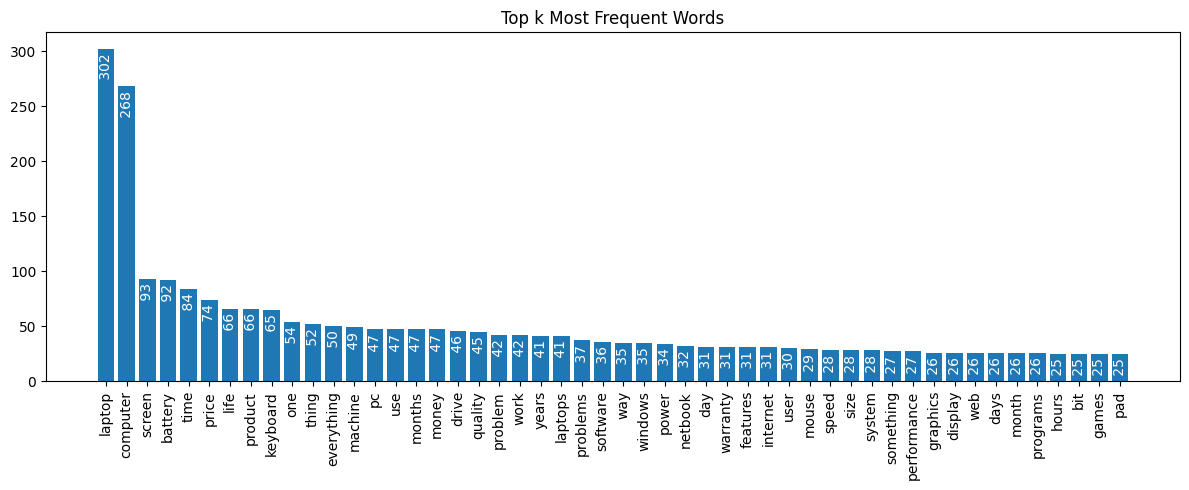

In [24]:
from tqdm.auto import tqdm
from unsupervised_absa.preprocess import plot_top_k_words
import json

with open('../data_2016/pos tag/laptop_pos_tag.json') as f:
    pos_tags = json.load(f)

list_of_words = []
for row in tqdm(pos_tags):
    for pos_data in row['pos_tag']:
        list_of_words.append(pos_data['word'])
plot_top_k_words(list_of_words, 50)

Remove nouns that occured only once

In [25]:
from functools import reduce
array_nouns = list(map(lambda x: [tag['word'].lower() for tag in x['pos_tag']], pos_tags))
nouns = reduce(lambda x,y :x+y , array_nouns)

In [26]:
from collections import Counter
counter = Counter(nouns)
words_to_filter = []
for word, count in counter.items():
    if count == 1:
        words_to_filter.append(word)

In [27]:
for row in tqdm(pos_tags):
    pos_tag = []
    for pos_data in row['pos_tag']:
        if pos_data['word'] not in words_to_filter:
            pos_tag.append(pos_data)
    row['pos_tag'] = pos_tag

  0%|          | 0/2488 [00:00<?, ?it/s]

In [28]:
with open("../data_2016/pos tag/laptop_pos_tag_low_counts.json", "w") as fp:
    json.dump(pos_tags, fp)

### Restaurant Pos Tag Analysis

Performing these pos tags for nouns will give us the candidate terms. 

  0%|          | 0/1990 [00:00<?, ?it/s]

<Axes: title={'center': 'Top k Most Frequent Words'}>

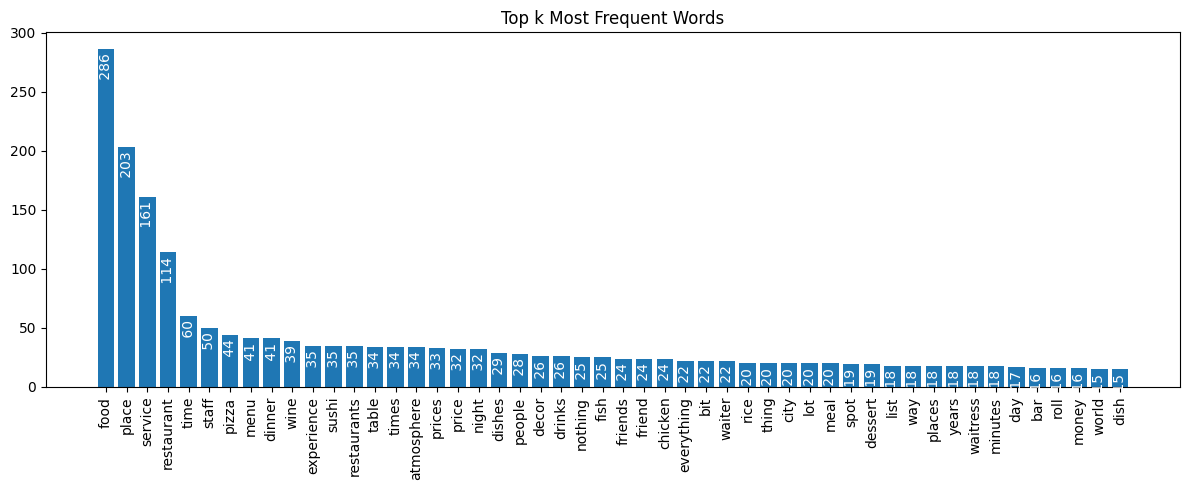

In [29]:
from tqdm.auto import tqdm
from unsupervised_absa.preprocess import plot_top_k_words
import json

with open('../data_2016/pos tag/restaurant_pos_tag.json') as f:
    pos_tags = json.load(f)

list_of_words = []
for row in tqdm(pos_tags):
    for pos_data in row['pos_tag']:
        list_of_words.append(pos_data['word'])
plot_top_k_words(list_of_words, 50)

Remove nouns that occured only once

In [30]:
from functools import reduce
array_nouns = list(map(lambda x: [tag['word'].lower() for tag in x['pos_tag']], pos_tags))
nouns = reduce(lambda x,y :x+y , array_nouns)

In [31]:
from collections import Counter
counter = Counter(nouns)
words_to_filter = []
for word, count in counter.items():
    if count == 1:
        words_to_filter.append(word)

In [32]:
for row in tqdm(pos_tags):
    pos_tag = []
    for pos_data in row['pos_tag']:
        if pos_data['word'] not in words_to_filter:
            pos_tag.append(pos_data)
    row['pos_tag'] = pos_tag

  0%|          | 0/1990 [00:00<?, ?it/s]

In [33]:
with open("../data_2016/pos tag/restaurant_pos_tag_low_counts.json", "w") as fp:
    json.dump(pos_tags, fp)